# ASL CNN Data Augmentation

In the [previous notebook](ASLPart2CNN.ipynb), we built a CNN model to classify the ASL dataset. In this notebook, we will look at how we can use data augmentation to improve the performance of our model.

The validation accuracy is still lagging behind the training accuracy, which is a sign of overfitting and the model getting confused. 

One method we can use to improve the model's performance is data augmentation. Data augmentation is a technique used to artificially increase the size of the training dataset by applying various transformations to the existing images. This helps the model generalize better and reduces overfitting.

The increase in size gives the model more images to learn from while training. The increase in variance helps the model ignore unimportant features and select only the features that are truly important in classification, allowing it to generalize better.

We will start with the exact same data and model as in the previous notebook and then apply data augmentation to see if it improves the model's performance as part of the training process.

## Loading data

The following code was outlined in the previous two examples.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import struct
import sys
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import zipfile

# Visualization tools
import torchvision
import torchvision.transforms.v2 as transforms
import torchvision.transforms.functional as F
import pandas as pd

sys.path.append("../")
import Utils

device = Utils.get_device()

DATASET_LOCATION = ""
if Utils.in_lab():
    DATASET_LOCATION = "/transfer/mnist_asl/"
else:
    DATASET_LOCATION = "./mnist_asl/"

print(f"Dataset location: {DATASET_LOCATION}")
pathlib.Path(DATASET_LOCATION).mkdir(parents=True, exist_ok=True)

Dataset location: ./mnist_asl/


In [2]:
train_df = pd.read_csv(f"{DATASET_LOCATION}sign_mnist_train.csv")
valid_df = pd.read_csv(f"{DATASET_LOCATION}sign_mnist_test.csv")

In [3]:
class ASLImages(Dataset):
    def __init__(self, base_df):
        x_df = base_df.copy()
        y_df = x_df.pop("label")
        x_df = x_df.values / 255  # Normalize values from 0 to 1
        x_df = x_df.reshape(-1, IMAGE_CHANNELS, IMAGE_WIDTH, IMAGE_HEIGHT)
        # send to device for processing
        self.xs = torch.tensor(x_df).float().to(device)
        self.ys = torch.tensor(y_df).to(device)

    def __getitem__(self, idx):
        x = self.xs[idx]
        y = self.ys[idx]
        return x, y

    def __len__(self):
        return len(self.xs)

In [4]:
BATCH_SIZE = 32
IMAGE_HEIGHT = 28
IMAGE_WIDTH = 28
IMAGE_CHANNELS = 1

train_data = ASLImages(train_df)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
train_N = len(train_loader.dataset)

valid_data = ASLImages(valid_df)
valid_loader = DataLoader(valid_data, batch_size=BATCH_SIZE)
valid_N = len(valid_loader.dataset)

## Building a Model

We going to use exactly the same model as in the previous notebook, however this model had a lot of repetition in the code, especially with the Convolution layers. We can re-factor this to be our own custom class and then add this as a layer in the base Sequential model, to do this we need to look at this code and see what parameters are changing and what we can make more generic.

```
nn.Conv2d(IMAGE_CHANNELS, 25, kernel_size, stride=1, padding=1),  # 25 x 28 x 28
nn.BatchNorm2d(25),
nn.ReLU(),
nn.MaxPool2d(2, stride=2),  # 25 x 14 x 14
# Second convolution
nn.Conv2d(25, 50, kernel_size, stride=1, padding=1),  # 50 x 14 x 14
nn.BatchNorm2d(50),
nn.ReLU(),
nn.Dropout(0.2),
nn.MaxPool2d(2, stride=2),  # 50 x 7 x 7
# Third convolution
nn.Conv2d(50, 75, kernel_size, stride=1, padding=1),  # 75 x 7 x 7
nn.BatchNorm2d(75),
nn.ReLU(),
nn.MaxPool2d(2, stride=2),  # 75 x 3 x 3
```

We can see that the only thing that is changing is the number of input channels and the number of output channels and the use  of dropouts. We can make this more generic by passing in these parameters as arguments to the class and then using them to create the layers.

In [5]:
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, dropout_p):
        kernel_size = 3
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size, stride=1, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.MaxPool2d(2, stride=2)
        )

    def forward(self, x):
        return self.model(x)

The forward method just needs to be updated to use the class variables that we have created, so it will evaluate the same as before.


In [6]:
flattened_img_size = 75 * 3 * 3
N_CLASSES = 24
# Input 1 x 28 x 28
model = nn.Sequential(
    ConvBlock(IMAGE_CHANNELS, 25, 0), # 25 x 14 x 14
    ConvBlock(25, 50, 0.2), # 50 x 7 x 7
    ConvBlock(50, 75, 0),  # 75 x 3 x 3
    # Flatten to Dense Layers
    nn.Flatten(),
    nn.Linear(flattened_img_size, 512),
    nn.Dropout(.3),
    nn.ReLU(),
    nn.Linear(512, N_CLASSES)
)

if device == "cuda":
    model = torch.compile(model.to(device))
model.to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters())


# [Torchvision Transforms](https://pytorch.org/vision/0.9/transforms.html)

We have used these before for simple transforms such as scaling, we will now look in more depth at some other transforms we can apply to augment our data and provide variance to the input data.

We will start by extracting an image from the data to process and see what the results are.

In [7]:

row_0 = train_df.head(1)
y_0 = row_0.pop('label')
# normalize the values to 0-1
x_0 = row_0.values / 255
# convert to an image
x_0 = x_0.reshape(IMAGE_CHANNELS, IMAGE_WIDTH, IMAGE_HEIGHT)
# transform to a tensor
x_0 = torch.tensor(x_0)
x_0.shape

torch.Size([1, 28, 28])

We can define a simple image plot functions to display the images.

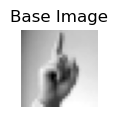

In [59]:
def plot_image(images, label, num_images=1,image_index=0):
    image = images.reshape(28, 28)
    plt.subplot(1, num_images, image_index + 1)
    plt.title(label)
    plt.axis("off")
    plt.imshow(image, cmap="gray")

plt.figure(figsize=(1, 1))
plot_image(x_0,"Base Image")

[RandomResizeCrop](https://pytorch.org/vision/0.9/transforms.html#torchvision.transforms.RandomResizedCrop)

This transform will apply both a crop and a resize to the image, the crop will be random and the resize will be to the size specified. It needs to know the aspect ratio of the image to be able to crop it correctly, however in our case it is 1:1 as the image is square.

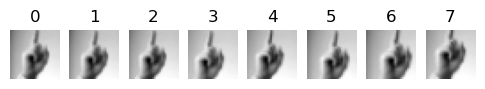

In [60]:
# as we are going to plot lots of images we may as well generate a function
def plot_multiple(num_images,transform,data,fig_size=(6,6)) :
    plt.figure(figsize=fig_size)
    for i in range(num_images) :
        new_x_0 = trans(x_0)
        plot_image(new_x_0,i,num_images,i)

trans = transforms.Compose([
    transforms.RandomResizedCrop((IMAGE_WIDTH, IMAGE_HEIGHT), scale=(.7, 1), ratio=(1, 1)),
])

plot_multiple(8,trans,x_0)

You can see the results are very subtle, but the image has changed enough to provide variance to the input data.

## [RandomHorizontalFlip](https://pytorch.org/vision/0.9/transforms.html#torchvision.transforms.RandomHorizontalFlip)

We can also randomly flip our images both horizontally and vertically, this will depend upon the data and what we are trying to do. In our case we are only going to flip the images horizontally, as this is the only way that the ASL data can be flipped and still be valid. (Note ASL is typically done with the dominant hand so both left or right handed is fine).


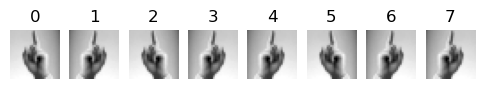

In [61]:
trans = transforms.Compose([
    transforms.RandomHorizontalFlip()
])

plot_multiple(8,trans,x_0)



## [RandomRotation](https://pytorch.org/vision/0.9/transforms.html#torchvision.transforms.RandomRotation)

We can also rotate the images by a random amount, but like the flipping we must be careful with this as the ASL data is very specific and we don't want to rotate the images too much as it will make the data invalid. We will limit the rotation to 20 degrees in either direction.

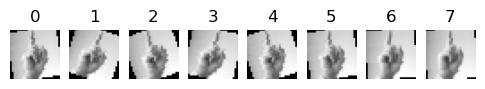

In [62]:
trans = transforms.Compose( [transforms.RandomRotation(20)] )

plot_multiple(8,trans,x_0)


Notice how this has added borders to the image, this is because the image has been rotated and the corners are now empty and set to an empty (black) pixel value.

## [ColorJitter](https://pytorch.org/vision/0.9/transforms.html#torchvision.transforms.ColorJitter)

The `ColorJitter` transform has 4 arguments:
    - brightness
    - contrast
    - saturation
    - hue

The saturation and hue apply to color images, so we will only use the first 2 for this example as we are using grayscale images.

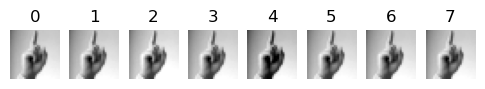

In [ ]:
brightness = .3
contrast = .5  

trans = transforms.Compose([
    transforms.ColorJitter(brightness=brightness, contrast=contrast)
])

plot_multiple(8,trans,x_0)



## [Compose](https://pytorch.org/vision/0.9/transforms.html#torchvision.transforms.Compose) 

It is possible to combine all of these transforms into a single transform using the `Compose` class, this will apply all of the transforms in the order that they are passed in.


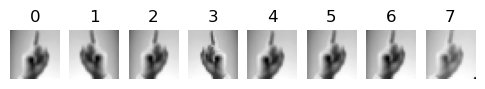

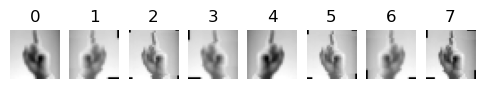

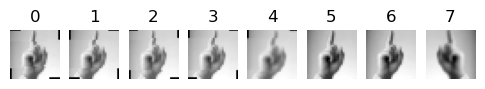

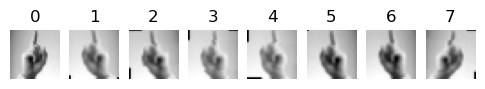

In [72]:


random_transforms = transforms.Compose([
        transforms.RandomRotation(5),
        transforms.RandomResizedCrop((IMAGE_WIDTH, IMAGE_HEIGHT), scale=(.9, 1), ratio=(1, 1)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=.2, contrast=.5)
    ])

for _ in range(4):
    plot_multiple(8,random_transforms,x_0)



## Training 

We will now train our model as before, however now we can pass in the transformation to our model, this will then apply it to each image before it is passed into the model.

As we are re-using a lot of code now, I have moved the get_batch_accuracy function into the Utils module and will use that instead. Note later we will also move the train / validate functions here too.

In [73]:
train_accuracy = []
train_loss = []

## note that some transforms don't work on the GPU on mps 
if device == "cuda" or device == "cpu" :
    random_transforms = transforms.Compose([
            transforms.RandomRotation(5),
            transforms.RandomResizedCrop((IMAGE_WIDTH, IMAGE_HEIGHT), scale=(.9, 1), ratio=(1, 1)),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=.2, contrast=.5)
    ])
else :
    random_transforms = transforms.Compose([
            transforms.RandomRotation(5),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=.2, contrast=.5)
    ])


def train():
    loss = 0
    accuracy = 0

    model.train()
    for x, y in train_loader:        
        # apply our random transform to the model input data
        output = model(random_transforms(x))
        optimizer.zero_grad()
        batch_loss = loss_function(output, y)
        batch_loss.backward()
        optimizer.step()

        loss += batch_loss.item()
        accuracy += Utils.get_batch_accuracy(output, y, train_N)
    train_accuracy.append(accuracy)
    train_loss.append(loss)
    print("Train - Loss: {:.4f} Accuracy: {:.4f}".format(loss, accuracy))

The validation remains the same as before and we don't add any transformations to the validation data, as we want to see how the model performs on the original data.

In [69]:
valid_accuracy = []
valid_loss = []


def validate():
    loss = 0
    accuracy = 0

    model.eval()
    with torch.no_grad():
        for x, y in valid_loader:
            output = model(x)
            loss += loss_function(output, y).item()
            accuracy += Utils.get_batch_accuracy(output, y, valid_N)
    valid_accuracy.append(accuracy)
    valid_loss.append(loss)
    print("Valid - Loss: {:.4f} Accuracy: {:.4f}".format(loss, accuracy))

In [74]:
epochs = 10

for epoch in range(epochs):
    print('Epoch: {}'.format(epoch))
    train()
    validate()

Epoch: 0
Train - Loss: 536.5103 Accuracy: 0.7564
Valid - Loss: 88.4414 Accuracy: 0.8093
Epoch: 1
Train - Loss: 72.0770 Accuracy: 0.9333
Valid - Loss: 27.7365 Accuracy: 0.9078
Epoch: 2
Train - Loss: 39.5368 Accuracy: 0.9449
Valid - Loss: 36.3511 Accuracy: 0.8968
Epoch: 3
Train - Loss: 32.8181 Accuracy: 0.9481
Valid - Loss: 23.4215 Accuracy: 0.9208
Epoch: 4
Train - Loss: 22.0398 Accuracy: 0.9513
Valid - Loss: 22.2003 Accuracy: 0.9208
Epoch: 5
Train - Loss: 23.5054 Accuracy: 0.9502
Valid - Loss: 22.3086 Accuracy: 0.9279
Epoch: 6
Train - Loss: 15.9701 Accuracy: 0.9532
Valid - Loss: 14.9483 Accuracy: 0.9328
Epoch: 7
Train - Loss: 19.4335 Accuracy: 0.9522
Valid - Loss: 22.7336 Accuracy: 0.9195
Epoch: 8
Train - Loss: 15.8578 Accuracy: 0.9537
Valid - Loss: 13.2136 Accuracy: 0.9324
Epoch: 9
Train - Loss: 15.5169 Accuracy: 0.9532
Valid - Loss: 24.5034 Accuracy: 0.9211
Epoch: 10
Train - Loss: 10.2839 Accuracy: 0.9551
Valid - Loss: 13.7528 Accuracy: 0.9303
Epoch: 11
Train - Loss: 13.1619 Accuracy:

We can plot our results as before and see how the model performs.

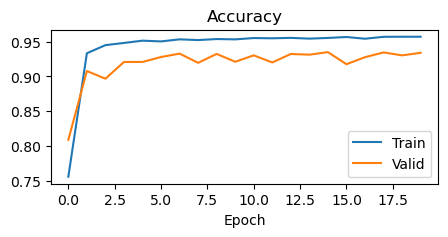

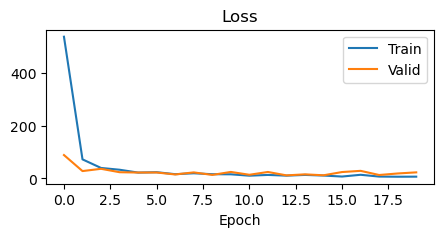

In [75]:
# Lets plot the data
plt.figure(figsize=(5, 2))
plt.plot(train_accuracy, label="Train")
plt.plot(valid_accuracy, label="Valid")
plt.xlabel("Epoch")
plt.title("Accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(5, 2))
plt.plot(train_loss, label="Train")
plt.plot(valid_loss, label="Valid")
plt.xlabel("Epoch")
plt.title("Loss")
plt.legend()
plt.show()

The results are much better, and it is not showing the signs of overfitting we had before. The validation accuracy is now much closer to the training accuracy and the model is performing much better. 

The training accuracy may be lower, and that's ok. Compared to before, the model is being exposed to a much larger variety of data.

## Testing the model.

We can now test the model as before and see how it performs on the test data.

In [ ]:
# Save the model
torch.save(model.state_dict(), "asl_model.pth")

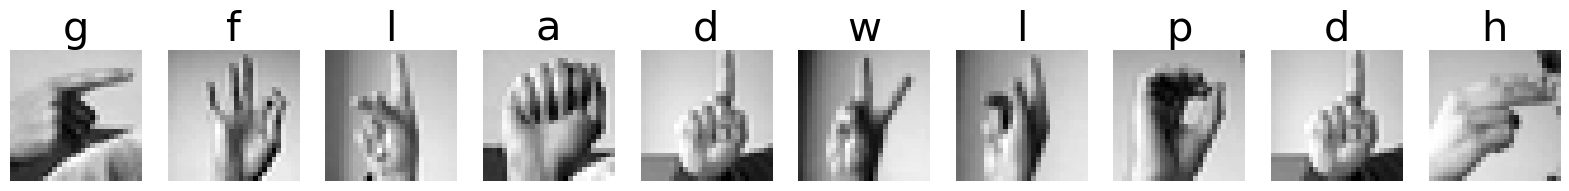

In [77]:
model.eval()
alphabet = "abcdefghiklmnopqrstuvwxy"
with torch.no_grad():
    # Get a batch of validation data
    # plot the image and the label
    x, y = next(iter(valid_loader))
    output = model(x)
    pred = output.argmax(dim=1, keepdim=True)
    num_images = 10
    plt.figure(figsize=(20, 20))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.title(alphabet[pred[i].item()], fontdict={"fontsize": 30})
        plt.axis("off")
        plt.imshow(x[i].cpu().numpy().reshape(28, 28), cmap="gray")